# Carvana Image Segmentation

In this notebook, we will be attempting to create a Segmentation Model to create segmentation masks for car-images found in this Kaggle challenge [here](https://www.kaggle.com/c/carvana-image-masking-challenge).

We will be creating a Deep Learning network based on the Tensorflow software package. For this notebook, our model will be based on a custom Convolutional Neural Network (CNN) that we will train from scratch.

In building the U-Net model for this segmentation task, our CNN will be responsible for the downsamping process (encoding). For the upsampling process (decoding) we will be using the Pix2Pix model from [Tensorflow](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

### 1. Data Import

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import pathlib
import glob
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/My Drive/Holmusk/'

In [5]:
cars_final = pd.read_csv(drive_path + 'data/train_final.csv')
cars_final.head()

,id,img,mask_file,rle_mask,year,make,model,trim1,trim2
0,00087a6bd4dc,00087a6bd4dc_01.jpg,00087a6bd4dc_01_mask.gif,879386 40 881253 141 883140 205 885009 17 8850...,2014.0,Acura,RLX,RLX,w/Tech
1,00087a6bd4dc,00087a6bd4dc_02.jpg,00087a6bd4dc_02_mask.gif,873779 4 875695 7 877612 9 879528 12 881267 15...,2014.0,Acura,RLX,RLX,w/Tech
2,00087a6bd4dc,00087a6bd4dc_03.jpg,00087a6bd4dc_03_mask.gif,864300 9 866217 13 868134 15 870051 16 871969 ...,2014.0,Acura,RLX,RLX,w/Tech
3,00087a6bd4dc,00087a6bd4dc_04.jpg,00087a6bd4dc_04_mask.gif,879735 20 881650 26 883315 92 883564 30 885208...,2014.0,Acura,RLX,RLX,w/Tech
4,00087a6bd4dc,00087a6bd4dc_05.jpg,00087a6bd4dc_05_mask.gif,883365 74 883638 28 885262 119 885550 34 88716...,2014.0,Acura,RLX,RLX,w/Tech


In [6]:
cars_final.shape

(5088, 9)

In [7]:
train, test = train_test_split(cars_final, random_state = 42)

In [8]:
train.shape

(3816, 9)

In [9]:
test.shape

(1272, 9)

In [10]:
image_URL = 'https://www.dropbox.com/s/nb40w6ajc8aqpm6/train.zip?dl=1'
image_path_to_zip = tf.keras.utils.get_file('train.zip', origin=image_URL, extract=True)
image_PATH = os.path.join(os.path.dirname(image_path_to_zip), 'train')

424239104/424233528 [==============================] - 3s 0us/step


In [11]:
image_PATH

'/root/.keras/datasets/train'

In [12]:
masks_URL = 'https://www.dropbox.com/s/h0yzq8mnay36cgc/train_masks.zip?dl=1'
masks_path_to_zip = tf.keras.utils.get_file('train_masks.zip', origin=masks_URL, extract=True)
masks_PATH = os.path.join(os.path.dirname(masks_path_to_zip), 'train_masks')

30539776/30537860 [==============================] - 0s 0us/step


In [13]:
masks_PATH

'/root/.keras/datasets/train_masks'

### 2. Create Image Dataset

In [14]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 127.5
    return input_image, input_mask

In [15]:
def load_image_and_mask(image_filename, mask_filename):
    
    image_string = tf.io.read_file(image_filename)
    image_decoded = tf.io.decode_jpeg(image_string,channels = 3)
    input_image = tf.image.resize(image_decoded, (160, 240))
    
    mask_string = tf.io.read_file(mask_filename)
    mask_decoded = tf.io.decode_jpeg(mask_string, channels = 3)     
    mask_grayscale = tf.image.rgb_to_grayscale(mask_decoded) #pixels will be 0 or 255
    input_mask = tf.image.resize(mask_grayscale, (160, 240))

    input_image, input_mask = normalize(input_image, input_mask) # mask pixels will be 0 or 2

    return input_image, input_mask

The original image size was 1280 X 1918. Since 1918 is not a multiple of 32, it is not ideal for training. So we decided to round it to 1280 X 1920, and then downsize it by a factor of 8, resulting in an image size of 160 X 240.

In [16]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [17]:
img_train = image_PATH + '/' + train['img']

In [18]:
mask_train = masks_PATH + '/' + train['mask_file']

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, mask_train))
train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
img_test = image_PATH + '/' + test['img']

In [21]:
mask_test = masks_PATH + '/' + test['mask_file']

In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, mask_test))
test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

This method of constructing the dataset can be a bit more complex, but it allows us to parse in the images in a more ordered pattern. We will then have better control in how we create the predictions as well, which will help for further model evaluation (for example, we can compare with our metadata to see which type of car is not classified as well as others)

In [24]:
def display(display_list):
    
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

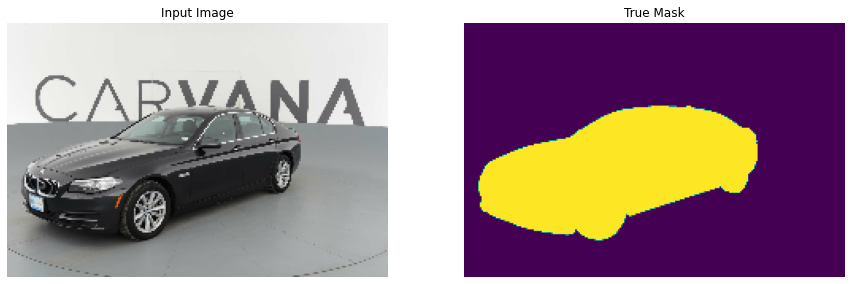

In [25]:
for image, mask in train_dataset.take(1):
    
    sample_image, sample_mask = image[1], mask[1]
    display([sample_image, sample_mask])

### 3. Create Model

In [26]:
base_model = keras.Sequential([layers.InputLayer(input_shape = (160, 240, 3)),
                               layers.Conv2D(64, kernel_size = 2, padding = 'same', activation='relu'),
                               layers.MaxPooling2D(2, 2),
                               layers.Conv2D(128, kernel_size = 2, padding = 'same', activation='relu'),
                               layers.MaxPooling2D(2, 2),
                               layers.Conv2D(256, kernel_size = 2, padding = 'same', activation='relu'),
                               layers.MaxPooling2D(2, 2),
                               layers.Conv2D(512, kernel_size = 2, padding = 'same', activation='relu'),
                               layers.MaxPooling2D(2, 2)])

In [27]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 240, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 120, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 120, 128)      32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 60, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 60, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 30, 512)       5

We use a simple 2D convolution followed by maxpooling layers. We tried using BatchNormalization layers as well but the model performed better (and took less time to train) without those layers.

In [28]:
layer_names = [
    'max_pooling2d',
    'max_pooling2d_1',
    'max_pooling2d_2',
    'max_pooling2d_3'
]

In [29]:
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [30]:
up_stack = [
    pix2pix.upsample(256, 3),  
    pix2pix.upsample(128, 3),  
    pix2pix.upsample(64, 3),  
]

In [31]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[160, 240, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [32]:
OUTPUT_CHANNELS = 3

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

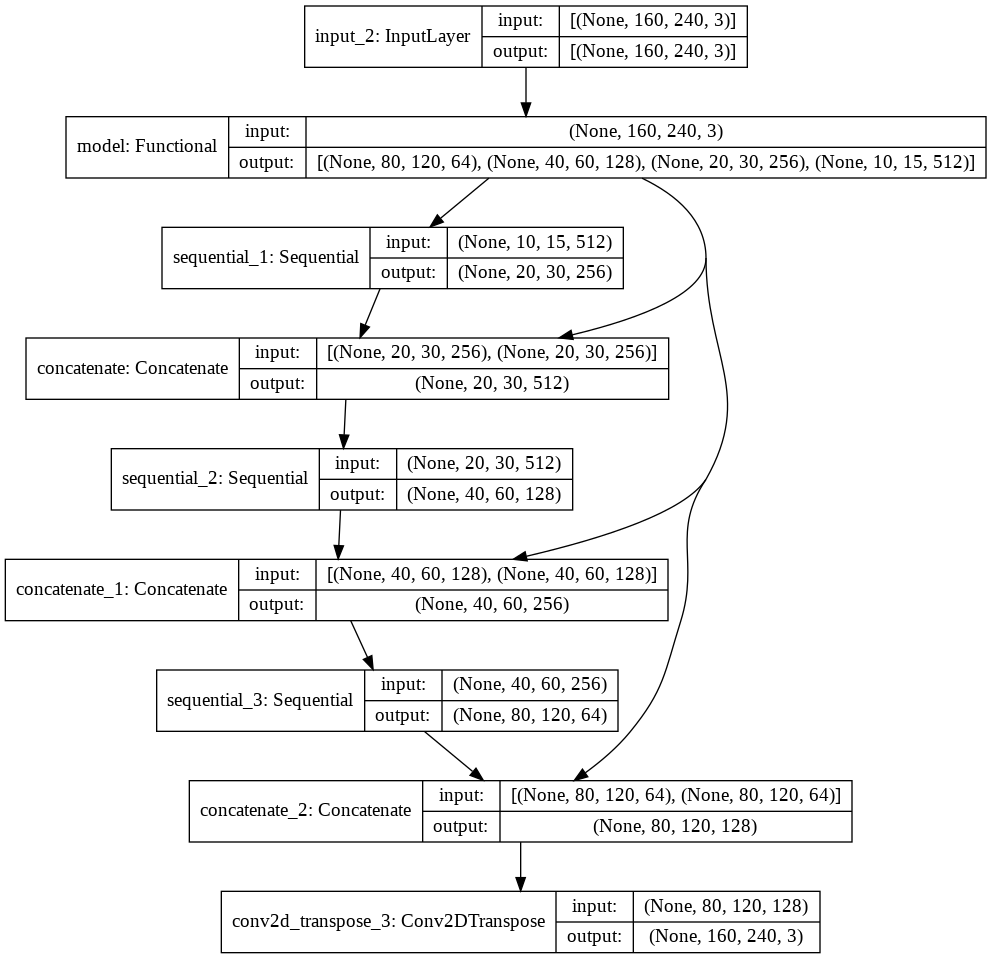

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True)
#to visualize how the model is constructed, with the upsampling/downsampling and concatenation

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 240, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 80, 120, 64) 689856      input_2[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 20, 30, 256)  1180672     model[0][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20, 30, 512)  0           sequential_1[0][0]               
                                                                 model[0][2]                

In [35]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [36]:
def show_predictions(dataset, num):

    for image, mask in dataset.take(num):
        
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask[0])])

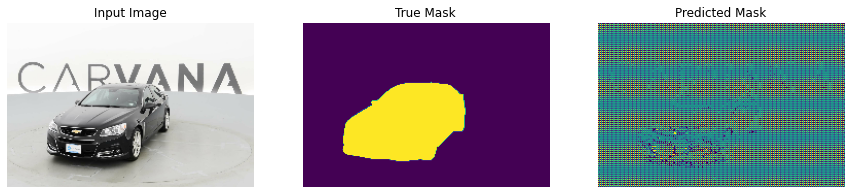

In [37]:
show_predictions(train_dataset, 1)

### 4. Model Training

In [38]:
class DisplayCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        
        clear_output(wait=True)
        show_predictions(test_dataset, 1)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
# creates a new class and function to display predictions after each epoch
# can choose not to use if we want a regular training output

In [39]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    min_delta=0.001,
    restore_best_weights=True)

In [40]:
EPOCHS = 15
TRAIN_LENGTH = train.shape[0]
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test.shape[0]//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[early_stopping])

Epoch 1/15
119/119 [==============================] - 147s 936ms/step - loss: 0.4029 - accuracy: 0.8595 - val_loss: 0.3261 - val_accuracy: 0.8664
Epoch 2/15
119/119 [==============================] - 30s 248ms/step - loss: 0.0454 - accuracy: 0.9847 - val_loss: 0.2736 - val_accuracy: 0.9063
Epoch 3/15
119/119 [==============================] - 29s 242ms/step - loss: 0.0335 - accuracy: 0.9883 - val_loss: 0.2533 - val_accuracy: 0.9223
Epoch 4/15
119/119 [==============================] - 29s 242ms/step - loss: 0.0280 - accuracy: 0.9901 - val_loss: 0.0384 - val_accuracy: 0.9865
Epoch 5/15
119/119 [==============================] - 29s 244ms/step - loss: 0.0242 - accuracy: 0.9914 - val_loss: 0.0248 - val_accuracy: 0.9915
Epoch 6/15
119/119 [==============================] - 29s 242ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0242 - val_accuracy: 0.9914
Epoch 7/15
119/119 [==============================] - 29s 242ms/step - loss: 0.0207 - accuracy: 0.9926 - val_loss: 0.0224 - val_a

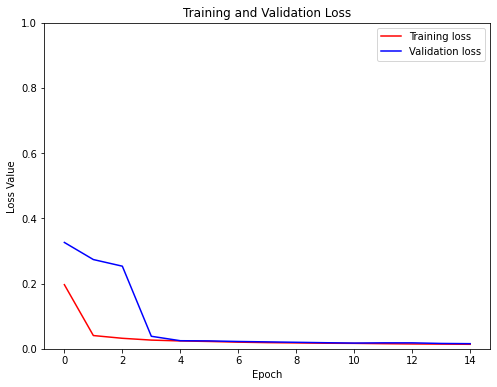

In [41]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize = (8, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

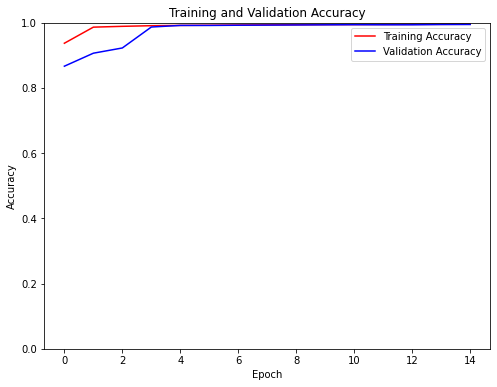

In [42]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure(figsize = (8, 6))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

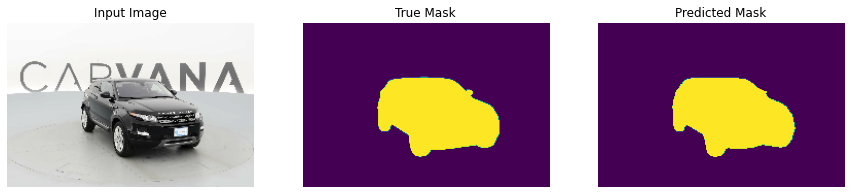

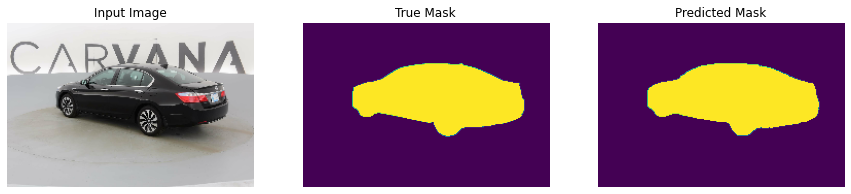

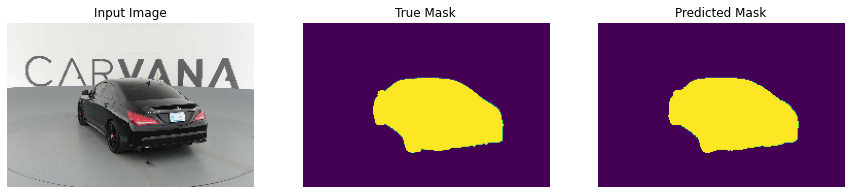

In [43]:
show_predictions(train_dataset, 3)

In [44]:
!pip install -q pyyaml h5py

In [45]:
model.save(drive_path + 'data/saved_model/240-160-CNN.h5')

### 5. Model Evaluation

As we can see, our model performs well with 99.4% for both Training and Validation accuracy. We tried creating a model based on the MobilenetV2 pre-trained CNN, but it did not perform better than our simple self-made CNN. MobilenetV2 is also not as ideal as it expects square images, and can only accept a max image size of (224 X 224). However, the Mobilenet model did manage to reach the same accuracy as our self-made CNN in 7 epochs instead of 15.

One weakness of our model is that our training is carried out on images that are (240 X 160) in size. We tried to run the model with a larger image size (480 X 320) but Colab crashed as it ran out of memory.